In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer

In [2]:
dev = qml.device('lightning.qubit', wires=9)

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Data generation

In this notebook we check the QGANs performance on a multimodal distribution.

As example we generate a double peak

In [4]:
N = 120

In [5]:
data1 = np.random.normal(loc=5,scale=1.5, size=N).astype(int)
data2 = np.random.normal(loc=11,scale=1.5, size=N).astype(int)

data = np.append(data1,data2)

In [6]:
values, counts = np.unique(data, return_counts=True)

In [7]:
x=np.arange(0,16)
zerovals = [i for i in x if i not in values]
zeros = np.zeros(len(zerovals))
values = np.append(values, zerovals)
counts = np.append(counts, zeros)

If we plot the data again we get the following distribution

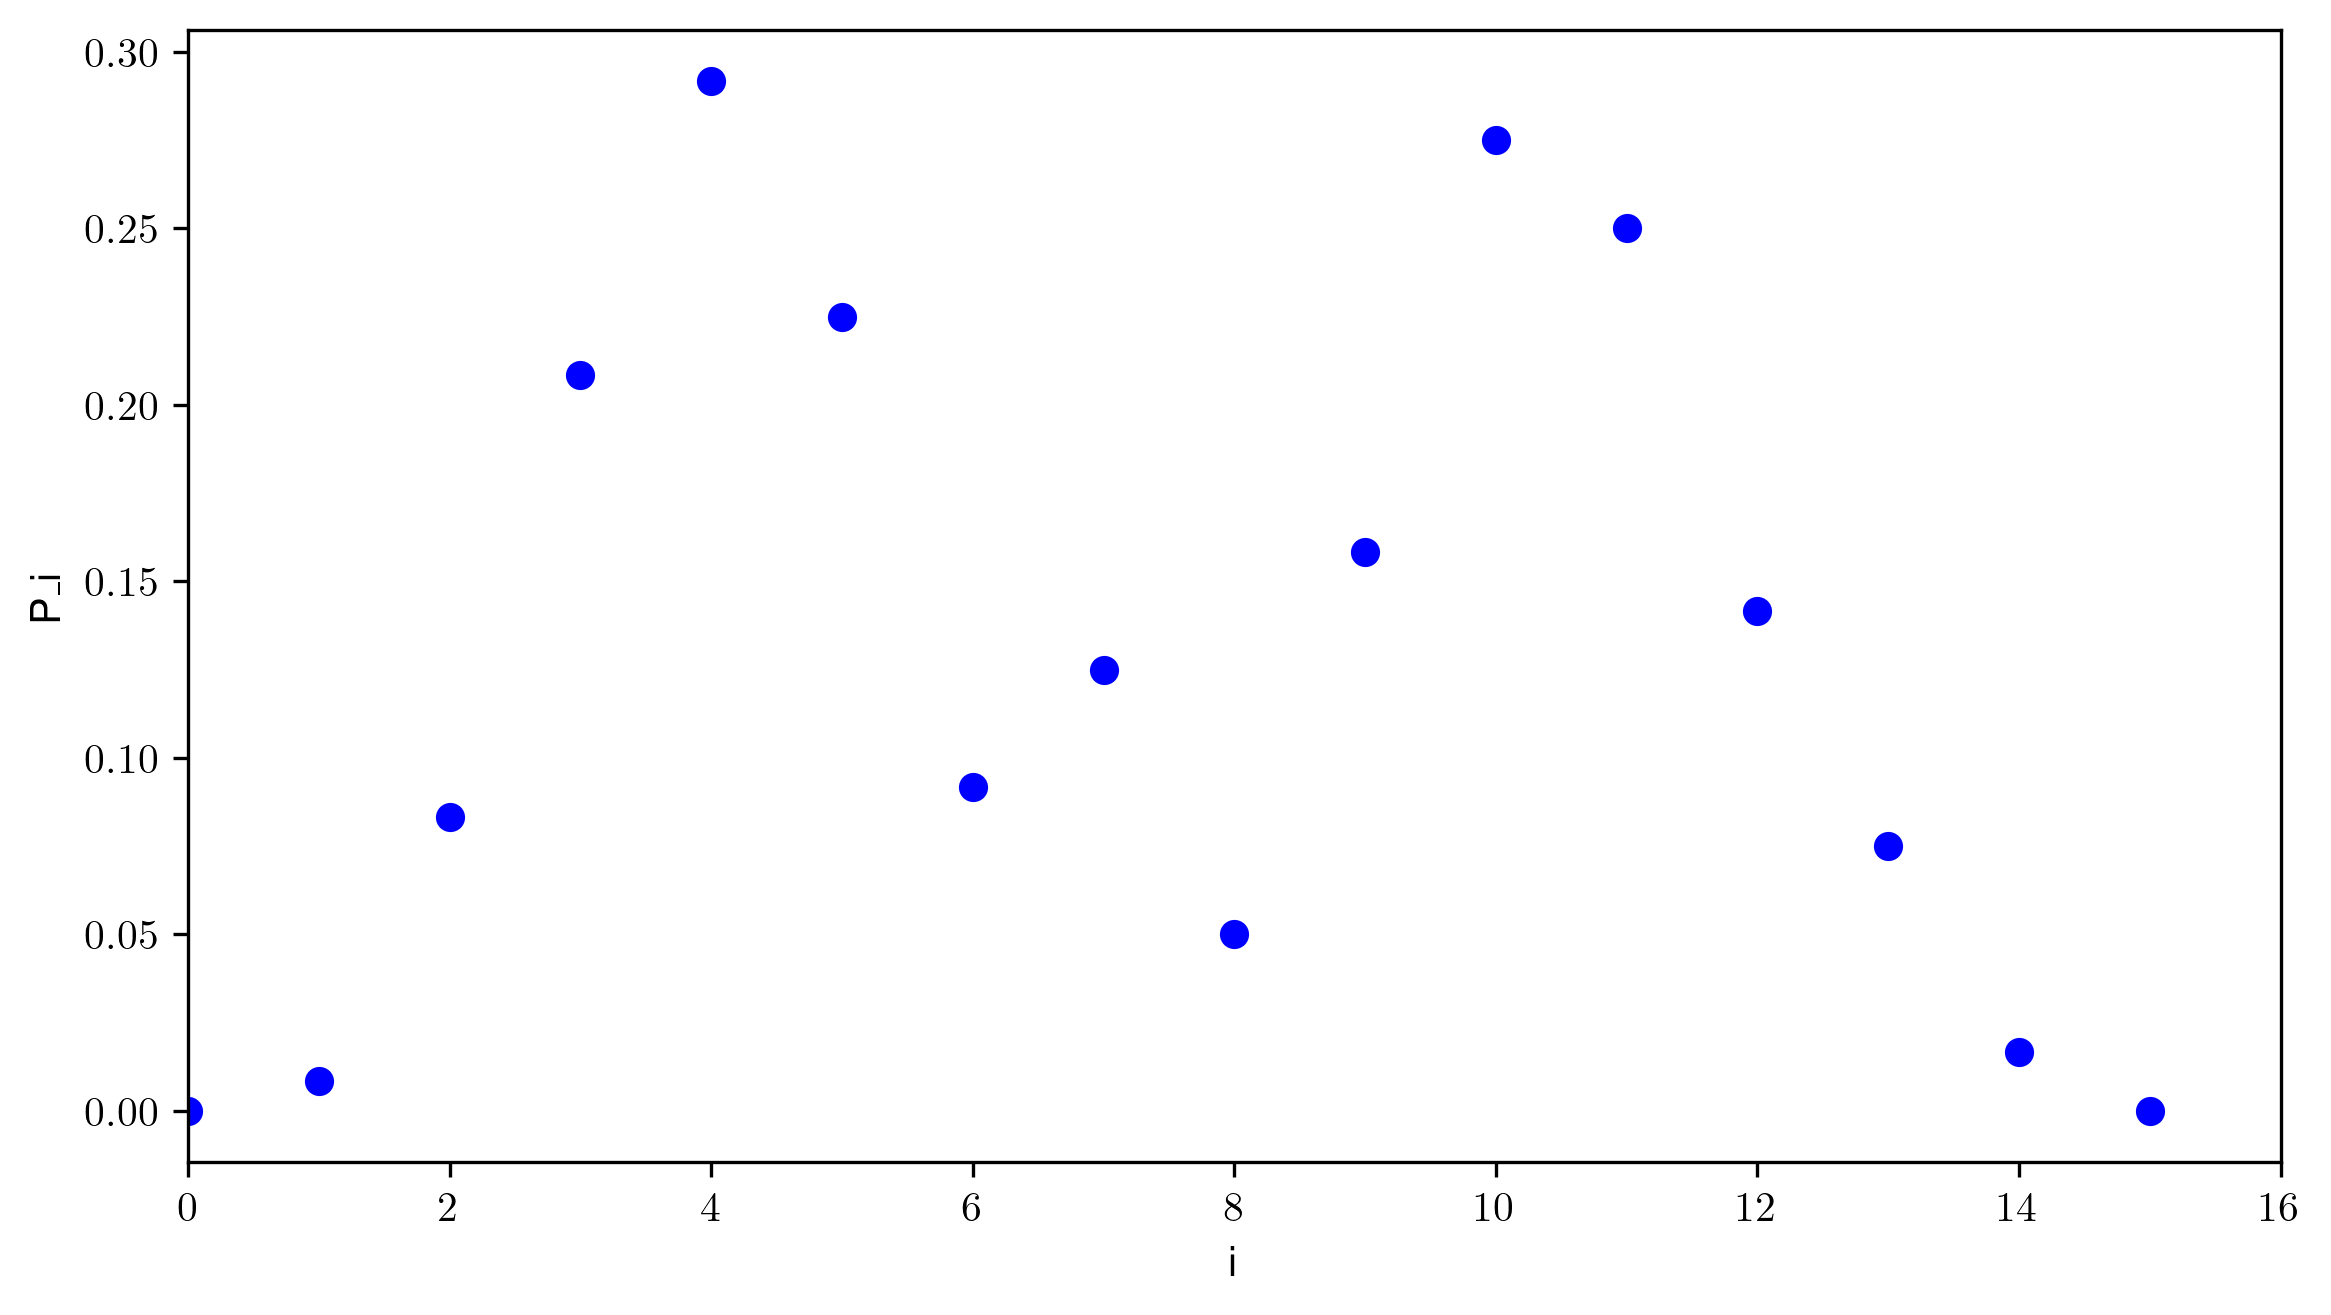

In [8]:
plt.figure(figsize=(9,5))
plt.plot(values,counts/N, 'b.', markersize=12)
plt.ylabel('P_i')
plt.xlabel('i')
plt.xlim(0,16)
plt.gcf().set_dpi(300)

In [9]:
def num_circuit(num, wires):
    bin_str = format(num, '#06b')[2:]
    for i, c in enumerate(bin_str):
        if c == '1':
            qml.PauliX(wires=i+wires[0])

## Model

The generator and training circuits look like in the simple peak example

In [10]:
def generator(params, qbits):
    qml.StronglyEntanglingLayers(weights=params, wires=[qbits[0],qbits[1],qbits[2],qbits[3]])

In [11]:
@qml.qnode(dev)
def training_circ(data, paramsg):
    # top 4 qbits real data
    num_circuit(data, [1,2,3,4])
    # bottom 4 qbits gen ansatz
    generator(paramsg, [5,6,7,8])
    # parametrized swap test
    qml.Hadamard(wires=0)
    qml.CSWAP(wires=[0,1,5])
    qml.CSWAP(wires=[0,2,6])
    qml.CSWAP(wires=[0,3,7])
    qml.CSWAP(wires=[0,4,8])
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(0))

## Training

The training is analogous to the simple single peak case.
Note that we choose more layers to be able to model the more complex unitarity neccessary to achive the double peak structure.

In [12]:
epochs = 15
batch_size=16
learning_rate=0.01
layers = 34

In [13]:
def cost_batch(paramsg, batch, reg=0.000001):
    loss = 0.0
    for i in batch:
        f = training_circ(i, paramsg) + reg
        loss += - np.log(f)
    return loss / len(batch)

In [14]:
paramsg = np.random.uniform(0,np.pi, size=(layers,4,3), requires_grad=True)

In [15]:
optg = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

In [16]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

In [17]:
losshist = []

start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=batch_size)):  
        cost_fn = lambda p: cost_batch(p, Xbatch)
        paramsg = optg.step(cost_fn, paramsg)
        print(j, end="\r")

    loss = cost_batch(paramsg, data)
    
    losshist += [loss]
    
    print(f"Epoch: {it} | Loss: {loss:.3} | ")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

Epoch: 0 | Loss: 3.15 | 
____
Epoch: 1 | Loss: 2.55 | 
____
Epoch: 2 | Loss: 2.52 | 
____
Epoch: 3 | Loss: 2.45 | 
____
Epoch: 4 | Loss: 2.44 | 
____
Epoch: 5 | Loss: 2.43 | 
____
Epoch: 6 | Loss: 2.44 | 
____
Epoch: 7 | Loss: 2.43 | 
____
Epoch: 8 | Loss: 2.44 | 
____
Epoch: 9 | Loss: 2.44 | 
____
Epoch: 10 | Loss: 3.09 | 
____
Epoch: 11 | Loss: 2.46 | 
____
Epoch: 12 | Loss: 2.45 | 
____
Epoch: 13 | Loss: 2.43 | 
____
Epoch: 14 | Loss: 2.46 | 
____
Time for 15 epochs: 98337.49949598312


## Evaluation

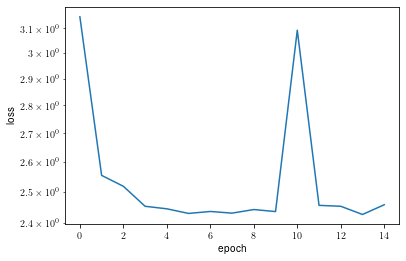

In [18]:
plt.plot(losshist)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')

In [19]:
sample_dev = qml.device('lightning.qubit', wires=4, shots=N)
@qml.qnode(sample_dev)
def sample_test():
    generator(paramsg, [0,1,2,3])
    return qml.sample()

In [20]:
testresult = [int(''.join(str(i) for i in a), 2) for a in sample_test()]

In [21]:
valuestest, countstest = np.unique(testresult, return_counts=True)

In [22]:
x=np.arange(0,16)
zerovals = [i for i in x if i not in valuestest]
zeros = np.zeros(len(zerovals))
valuestest = np.append(valuestest, zerovals)
countstest = np.append(countstest, zeros)

x=np.arange(0,16)
zerovals = [i for i in x if i not in values]
zeros = np.zeros(len(zerovals))
values = np.append(values, zerovals)
counts = np.append(counts, zeros)

As we can see, the gan does indeed start to model the double peak structure, however the convergence is much worse compared to the simple singel peak dataset.

(0.0, 16.0)

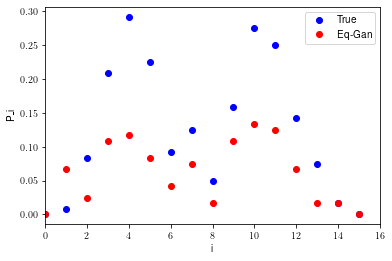

In [23]:
plt.plot(values,counts/N, 'b.', markersize=12, label="True")
plt.plot(valuestest,countstest/N, 'r.', markersize=12, label="Eq-Gan")
plt.ylabel('P_i')
plt.xlabel('i')
plt.legend()
plt.xlim(0,16)